# CatBoost Tabular Playground Prediction(Sep 2021)
## Table of Contents
- Import Packages
- Import Datasets
- EDA & Preprocessing
- Model Development & Evaluation
- Submission

## Import Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, log_loss, roc_auc_score

## Import datasets

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.head()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
0,0,0.10859,0.004314,-37.566,0.017364,0.28915,-10.25100,135.12,168900.0,3.992400e+14,...,-12.2280,1.7482,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.1,1.01770,1
1,1,0.10090,0.299610,11822.000,0.276500,0.45970,-0.83733,1721.90,119810.0,3.874100e+15,...,-56.7580,4.1684,0.34808,4.14200,913.23,1.2464,7.575100e+15,1861.0,0.28359,0
2,2,0.17803,-0.006980,907.270,0.272140,0.45948,0.17327,2298.00,360650.0,1.224500e+13,...,-5.7688,1.2042,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.2,0.40690,1
3,3,0.15236,0.007259,780.100,0.025179,0.51947,7.49140,112.51,259490.0,7.781400e+13,...,-34.8580,2.0694,0.79631,-16.33600,4952.40,1.1784,4.533000e+12,4889.1,0.51486,1
4,4,0.11623,0.502900,-109.150,0.297910,0.34490,-0.40932,2538.90,65332.0,1.907200e+15,...,-13.6410,1.5298,1.14640,-0.43124,3856.50,1.4830,-8.991300e+12,NaN,0.23049,1


In [4]:
test.head()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118
0,957919,0.165850,0.487050,1295.00,0.02310,0.31900,0.90188,573.29,3743.7,2.705700e+12,...,0.16253,-22.1890,2.0655,0.430880,-10.7410,81606.0,1.1940,1.980400e+14,2017.1,0.46357
1,957920,0.129650,0.373480,1763.00,0.72884,0.33247,-1.26310,875.55,554370.0,5.955700e+14,...,0.81528,-1.6342,1.5736,-1.071200,11.8320,90114.0,1.1507,4.388000e+16,6638.9,0.28125
2,957921,0.120190,0.445210,736.26,0.04615,0.29605,0.31665,2659.50,317140.0,3.977800e+14,...,0.81831,-32.7800,2.1364,-1.931200,-3.2804,37739.0,1.1548,1.718100e+14,5844.0,0.13797
3,957922,0.054008,0.395960,996.14,0.85934,0.36678,-0.17060,386.56,325680.0,-3.432200e+13,...,0.86559,-2.4162,1.5199,-0.011633,1.3840,26849.0,1.1490,2.138800e+17,6173.3,0.32910
4,957923,0.079947,-0.006919,10574.00,0.34845,0.45008,-1.84200,3027.00,428150.0,9.291500e+11,...,0.25190,-18.6300,3.7387,0.757080,-4.9405,50336.0,1.2488,2.151300e+17,2250.1,0.33796


## EDA & Data Preprocessing

### Drop ID columns

In [5]:
train.pop("id")
test_ids = test.pop("id")

### Get Train data Targets

In [6]:
train_targets = train.pop("claim")

In [7]:
train_targets.head()

0    1
1    0
2    1
3    1
4    1
Name: claim, dtype: int64

The labels looks balanced. 

C:\Users\Rahul\Miniconda3\envs\ml\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='claim', ylabel='count'>

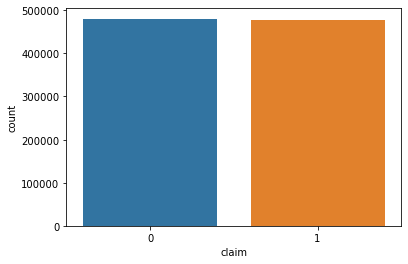

In [8]:
sns.countplot(train_targets)

Let's see statistic info between train set and test set and compare their differences, which are very small execpt for their total numbers.  Some of the parameters has a great difference, so I will apply log transformation to reduce their skewness.

In [9]:
train_desc = train.describe()
train_desc.transpose()

,count,mean,std,min,25%,50%,75%,max
f1,942672.0,9.020086e-02,4.356374e-02,-1.499100e-01,7.022700e-02,9.013500e-02,1.165000e-01,4.151700e-01
f2,942729.0,3.459637e-01,1.462507e-01,-1.904400e-02,2.830500e-01,3.891000e-01,4.584500e-01,5.189900e-01
f3,942428.0,4.068744e+03,6.415829e+03,-9.421700e+03,4.184300e+02,1.279500e+03,4.444400e+03,3.954400e+04
f4,942359.0,2.012140e-01,2.125103e-01,-8.212200e-02,3.508650e-02,1.370000e-01,2.971000e-01,1.319900e+00
f5,942514.0,3.048693e-01,1.453425e-01,-6.989800e-03,2.405200e-01,3.277900e-01,4.128300e-01,5.547500e-01
...,...,...,...,...,...,...,...,...
f114,942481.0,6.315297e+04,9.243502e+04,-8.197700e+04,2.443200e+03,1.947900e+04,8.848800e+04,5.260500e+05
f115,942360.0,1.208876e+00,1.149588e-01,9.052700e-01,1.146800e+00,1.177200e+00,1.242000e+00,1.886700e+00
f116,942330.0,4.276905e+16,6.732441e+16,-8.944400e+15,2.321100e+14,1.327500e+16,5.278700e+16,3.249900e+17
f117,942512.0,3.959205e+03,3.155992e+03,-4.152400e+02,1.306200e+03,3.228000e+03,6.137900e+03,1.315100e+04


In [10]:
test_desc = test.describe()
test_desc.transpose()

,count,mean,std,min,25%,50%,75%,max
f1,485662.0,9.019114e-02,4.353777e-02,-1.531900e-01,7.021100e-02,9.017300e-02,1.165075e-01,4.129000e-01
f2,485583.0,3.461425e-01,1.458888e-01,-1.906000e-02,2.836600e-01,3.889400e-01,4.583100e-01,5.198800e-01
f3,485679.0,4.047202e+03,6.383225e+03,-9.436300e+03,4.188350e+02,1.277900e+03,4.421400e+03,3.984100e+04
f4,485741.0,2.015029e-01,2.125533e-01,-8.071600e-02,3.516900e-02,1.373500e-01,2.971600e-01,1.310200e+00
f5,485597.0,3.048788e-01,1.454351e-01,-7.006900e-03,2.406000e-01,3.280200e-01,4.128100e-01,5.555800e-01
...,...,...,...,...,...,...,...,...
f114,485532.0,6.305129e+04,9.227903e+04,-8.138100e+04,2.474875e+03,1.942900e+04,8.830950e+04,5.215400e+05
f115,485497.0,1.209049e+00,1.150736e-01,9.007000e-01,1.146800e+00,1.177200e+00,1.242300e+00,1.877900e+00
f116,485391.0,4.284258e+16,6.743966e+16,-7.749400e+15,2.317850e+14,1.330400e+16,5.284700e+16,3.239500e+17
f117,485711.0,3.968586e+03,3.161273e+03,-4.162400e+02,1.310000e+03,3.237100e+03,6.157300e+03,1.319800e+04


In [11]:
desc_delta = train_desc - test_desc
desc_delta.transpose()

,count,mean,std,min,25%,50%,75%,max
f1,457010.0,9.723625e-06,2.597197e-05,3.280000e-03,1.600000e-05,-3.800000e-05,-7.500000e-06,2.270000e-03
f2,457146.0,-1.788055e-04,3.619441e-04,1.600000e-05,-6.100000e-04,1.600000e-04,1.400000e-04,-8.900000e-04
f3,456749.0,2.154181e+01,3.260448e+01,1.460000e+01,-4.050000e-01,1.600000e+00,2.300000e+01,-2.970000e+02
f4,456618.0,-2.889054e-04,-4.290765e-05,-1.406000e-03,-8.250000e-05,-3.500000e-04,-6.000000e-05,9.700000e-03
f5,456917.0,-9.531270e-06,-9.253989e-05,1.710000e-05,-8.000000e-05,-2.300000e-04,2.000000e-05,-8.300000e-04
...,...,...,...,...,...,...,...,...
f114,456949.0,1.016860e+02,1.559844e+02,-5.960000e+02,-3.167500e+01,5.000000e+01,1.785000e+02,4.510000e+03
f115,456863.0,-1.730104e-04,-1.147484e-04,4.570000e-03,0.000000e+00,0.000000e+00,-3.000000e-04,8.800000e-03
f116,456939.0,-7.352366e+13,-1.152458e+14,-1.195000e+15,3.250000e+11,-2.900000e+13,-6.000000e+13,1.040000e+15
f117,456801.0,-9.380843e+00,-5.281491e+00,1.000000e+00,-3.800000e+00,-9.100000e+00,-1.940000e+01,-4.700000e+01


## Feature Scaling

In [12]:
for item in train.columns:
    if abs(train[item].max()) / (abs(train[item].min()) + 10e-10) > 10:
        train[item] = np.sign(train[item]) * np.log2(np.abs(train[item]) + 1)
        test[item] = np.sign(test[item]) * np.log2(np.abs(test[item]) + 1)
    train_mean = train[item].mean()
    train_std = train[item].std()
    train[item] = (train[item] - train_mean) / train_std
    test[item] = (test[item] - train_mean) / train_std
    # Missing Value Imputation seems to have a bad effect to final results
    #train[item].replace(np.NAN, train[item].mean(), inplace=True)
    #test[item].replace(np.NAN, test[item].mean(), inplace=True)


### Train Validation Split

In [13]:
train_features, valid_features, train_targets, valid_targets = train_test_split(train, train_targets, test_size=0.2, random_state=np.random.randint(1000))
train_features.shape, train_targets.shape, valid_features.shape, valid_targets.shape

((766335, 118), (766335,), (191584, 118), (191584,))

## Model Development & Evaluation


### Evaluation Method

In [14]:
def evaluate(valid_targets, probs, name):
    y_pred = np.array(probs > 0.5, dtype=int)
    acc = accuracy_score(valid_targets, y_pred)
    loss = log_loss(valid_targets, y_pred)
    auc = roc_auc_score(valid_targets, probs)
    print("Accuracy score: %.2f"%(acc))
    print("Log loss: %.2f"%(loss))
    print("AUC score:", auc)
    print("Classification report:")
    print(classification_report(valid_targets, y_pred))
    return {
        "name": name, 
        "accuracy_score": acc, 
        "log_loss": loss, 
        "auc": auc
    }

In [15]:
train_features.shape

(766335, 118)

## Using CatBoost

In [22]:
cat_params = {
    'iterations': 15000, 
    'loss_function': 'Logloss', 
    'depth': 7, 
    'task_type' : 'GPU',
    'use_best_model': True,
    'eval_metric': 'AUC',
    'early_stopping_rounds': 1000,
    'learning_rate': 0.02,
    'border_count': 32,
    'l2_leaf_reg': 3,
    "verbose": 1000
}
cat = CatBoostClassifier(
    **cat_params
)
cat.fit(train_features, train_targets, eval_set=[(valid_features, valid_targets)])

0:	learn: 0.5518146	test: 0.5508419	best: 0.5508419 (0)	total: 39.6ms	remaining: 9m 53s
1000:	learn: 0.8031782	test: 0.7976518	best: 0.7976518 (1000)	total: 52.5s	remaining: 12m 14s
2000:	learn: 0.8094440	test: 0.8000313	best: 0.8000313 (2000)	total: 1m 54s	remaining: 12m 26s
3000:	learn: 0.8144549	test: 0.8008842	best: 0.8008842 (2998)	total: 3m 27s	remaining: 13m 51s
4000:	learn: 0.8192819	test: 0.8014015	best: 0.8014015 (4000)	total: 4m 53s	remaining: 13m 27s
5000:	learn: 0.8241102	test: 0.8017505	best: 0.8017505 (5000)	total: 5m 29s	remaining: 10m 59s
6000:	learn: 0.8290019	test: 0.8019897	best: 0.8019915 (5994)	total: 6m 4s	remaining: 9m 6s
7000:	learn: 0.8338774	test: 0.8022176	best: 0.8022190 (6993)	total: 6m 43s	remaining: 7m 40s
8000:	learn: 0.8388107	test: 0.8024215	best: 0.8024232 (7995)	total: 7m 20s	remaining: 6m 25s
9000:	learn: 0.8436971	test: 0.8026317	best: 0.8026328 (8999)	total: 7m 57s	remaining: 5m 18s
10000:	learn: 0.8485550	test: 0.8027357	best: 0.8027409 (9954)	t

In [23]:
probs = cat.predict_proba(valid_features)[:, 1]
probs[:10]

array([0.81868803, 0.86277838, 0.87330389, 0.22623365, 0.51253656,
       0.20610893, 0.59941892, 0.85758601, 0.45039556, 0.58375224])

In [24]:
result_cat = evaluate(valid_targets, probs, "catboost")
result_cat

Accuracy score: 0.75
Log loss: 8.75
AUC score: 0.8030228196692537
Classification report:
              precision    recall  f1-score   support

           0       0.74      0.77      0.75     95999
           1       0.76      0.73      0.74     95585

    accuracy                           0.75    191584
   macro avg       0.75      0.75      0.75    191584
weighted avg       0.75      0.75      0.75    191584



{'name': 'catboost',
 'accuracy_score': 0.7467064055453483,
 'log_loss': 8.7485447023782,
 'auc': 0.8030228196692537}

## Submisssion

In [25]:
claim = cat.predict_proba(test)[:, 1]
submission = pd.DataFrame({"id": list(test_ids), "claim": claim.reshape(-1)})
submission.to_csv("submission.csv", index=False)